# Process xCell cell-type genesets

The genesets were extracted from additional file 3 in [Aran et al. 2017](https://doi.org/10.1186/s13059-017-1349-1 "xCell: digitally portraying the tissue cellular heterogeneity landscape"). The data consist of 489 gene signatures. Many of these signatures represent redundant cell-types with different evidence.

In [4]:
import os
from datetime import datetime
import csv
import pandas as pd

In [2]:
%matplotlib inline

In [5]:
# Load Additional File 3
xcell_file = os.path.join('data', '13059_2017_1349_MOESM3_ESM.xlsx')
xcell_df = pd.read_excel(xcell_file, index_col=0)
print(xcell_df.shape)
xcell_df.head()

(489, 201)


/Users/randolab/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,# of genes,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199,Unnamed: 200,Unnamed: 201
Celltype_Source_ID,,,,,,,,,,,,,,,,,,,,,
aDC_HPCA_1,8,C1QA,C1QB,CD80,IL12B,CCL13,CCL17,CCL19,CCL22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aDC_HPCA_2,10,C1QA,C1QB,CD80,FPR3,HLA-DQA1,IL12B,CCL13,CCL17,CCL19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aDC_HPCA_3,10,C1QA,C1QB,CD80,FPR3,HLA-DQA1,IL12B,CCL13,CCL17,CCL19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aDC_IRIS_1,19,CD80,IL3RA,IL12B,CXCL9,PTGIR,CCL8,CCL13,CCL17,CCL19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aDC_IRIS_2,173,ACHE,ADPRH,ALOX15B,ANXA5,XIAP,ARF3,RHOG,ATP1B3,BLVRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Distribution of number of cell types
cell_types = pd.Series([x.split('_')[0] for x in xcell_df.index])
cell_types.value_counts().head(10)

Monocytes             15
CD8+ T-cells          15
NK cells              15
Macrophages           12
Neutrophils           12
Erythrocytes          12
MPP                   12
DC                    12
Endothelial cells     12
CD4+ naive T-cells    12
Name: count, dtype: int64

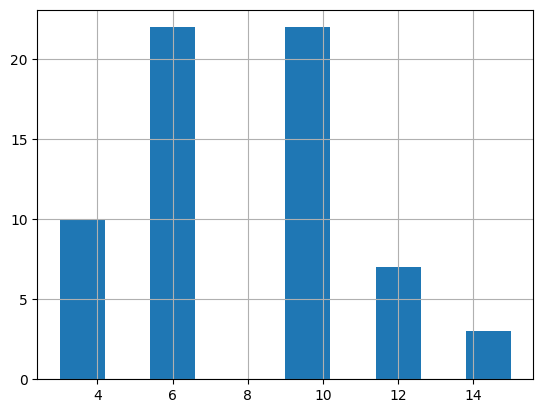

In [7]:
# Distribution of number of cell types
cell_types.value_counts().hist(bins=10);

In [8]:
# Load curated gene names from versioned resource 
commit = '721204091a96e55de6dcad165d6d8265e67e2a48'
url = 'https://raw.githubusercontent.com/cognoma/genes/{}/data/genes.tsv'.format(commit)
gene_df = pd.read_table(url)

# Only consider protein-coding genes
gene_df = (
    gene_df.query("gene_type == 'protein-coding'")
)

symbol_to_entrez = dict(zip(gene_df.symbol,
                            gene_df.entrez_gene_id))

In [9]:
# Add alternative symbols to entrez mapping dictionary
gene_df = gene_df.dropna(axis='rows', subset=['synonyms'])
gene_df.synonyms = gene_df.synonyms.str.split('|')

all_syn = (
    gene_df.apply(lambda x: pd.Series(x.synonyms), axis=1)
    .stack()
    .reset_index(level=1, drop=True)
)

# Name the synonym series and join with rest of genes
all_syn.name = 'all_synonyms'
gene_with_syn_df = gene_df.join(all_syn)

# Remove rows that have redundant symbols in all_synonyms
gene_with_syn_df = (
    gene_with_syn_df
    
    # Drop synonyms that are duplicated - can't be sure of mapping
    .drop_duplicates(['all_synonyms'], keep=False)

    # Drop rows in which the symbol appears in the list of synonyms
    .query('symbol not in all_synonyms')
)

In [10]:
# Create a synonym to entrez mapping and add to dictionary
synonym_to_entrez = dict(zip(gene_with_syn_df.all_synonyms,
                             gene_with_syn_df.entrez_gene_id))

symbol_to_entrez.update(synonym_to_entrez)

<Axes: >

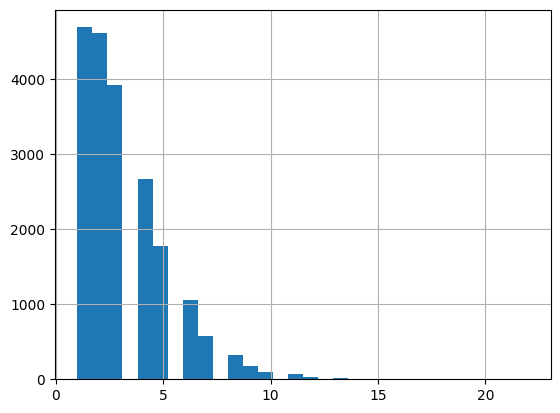

In [11]:
# How many entrez genes match to duplicate symbols
pd.DataFrame.from_dict(symbol_to_entrez, orient='index').loc[:, 0].value_counts().hist(bins=30)

In [10]:
# Load gene updater
url = 'https://raw.githubusercontent.com/cognoma/genes/{}/data/updater.tsv'.format(commit)
updater_df = pd.read_table(url)
old_to_new_entrez = dict(zip(updater_df.old_entrez_gene_id,
                             updater_df.new_entrez_gene_id))

In [11]:
geneset_url = 'https://doi.org/10.1186/s13059-017-1349-1'
xcell_gmt_file = os.path.join('data', 'xcell_all_entrez.gmt')

with open(xcell_gmt_file, 'w') as csvfile:
    xcell_writer = csv.writer(csvfile, delimiter='\t')
    for row in xcell_df.iterrows():
        geneset_name = row[0].replace(' ', '-')
        genes = row[1][2:].dropna().tolist()

        # There are data issues of input datetime types
        # Ignore these genes for now
        # See https://doi.org/10.1186/s13059-016-1044-7
        genes = [x for x in genes if not type(x) == datetime.date]

        # Convert genes to entrez IDs (considering alternate mappings)
        genes = [symbol_to_entrez[x] for x in genes if x in symbol_to_entrez]

        # Remove empty cells in the cell file
        #genes = [x for x in genes if x != '']
        row_to_write = [geneset_name, geneset_url] + list(set(genes))
        xcell_writer.writerow(row_to_write)